# Baseline Model

In [543]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Preprocessing

In [544]:
df = pd.read_csv("final_enriched_dataset.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
london_df = df[df["city"].str.lower() == "london"].copy()
london_df.head(5)

/var/folders/fc/6yc1nz0x6x7fmdkjy4089fdh0000gn/T/ipykernel_15219/3143619313.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("final_enriched_dataset.csv")


,sale_price,bedrooms,bathrooms,living_area,postcode,city,country,dataset_date,currency,sale_price_usd,...,num_dining_drinking,num_retail_shopping,num_education,num_recreation,num_entertainment,num_transportation,num_healthcare,num_professional,num_high_rating_venues,median_income
74072,1675000.0,5.0,5.0,2716.0,SW198NY,London,UK,2018-09-02,GBP,2164528.8,...,25,13,2,0,3,0,1,1,12,105000.0
74073,650000.0,2.0,2.0,814.0,EC1V3PA,London,UK,2018-09-02,GBP,839966.4,...,36,2,1,0,6,1,0,0,39,70875.0
74074,650000.0,2.0,2.0,814.0,EC1V3PA,London,UK,2018-09-02,GBP,839966.4,...,36,2,1,0,6,1,0,0,39,70875.0
74075,650000.0,2.0,2.0,814.0,EC1V3PA,London,UK,2018-09-02,GBP,839966.4,...,36,2,1,0,6,1,0,0,39,70875.0
74076,650000.0,2.0,2.0,814.0,EC1V3PA,London,UK,2018-09-02,GBP,839966.4,...,36,2,1,0,6,1,0,0,39,70875.0


In [545]:
y = london_df["sale_price_usd_inflation_adjusted"]
X = london_df.drop(columns=["sale_price", "sale_price_usd", "sale_price_usd_inflation_adjusted"])

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

# Do split (70/15/15)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.17647, random_state=42
)

print(f"Train/Val/Test sizes: {len(X_train)}/{len(X_val)}/{len(X_test)}")

Train/Val/Test sizes: 4000/858/858


In [546]:
# Data preprocessing
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="missing")),
    ("oh",     OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline,     num_cols),
    ("cat", categorical_pipeline, cat_cols),
], remainder="drop")

## Linear Regression

In [547]:
model = Pipeline([
    ("prep", preprocess),
    ("reg",  LinearRegression()),
])

model.fit(X_train, y_train)

print('***** Results of linear regression model on London dataset *****')

predictions_train = model.predict(X_train)
score_mse_train = mean_squared_error(y_train, predictions_train)
score_rmse_train = np.sqrt(score_mse_train)
print('Training set RMSE: {:.4f}'.format(score_rmse_train))

score_r2_train = r2_score(y_train, predictions_train)
print('Training set r-squared scores: {:.4f}'.format(score_r2_train))

predictions_test = model.predict(X_test)
score_mse_test = mean_squared_error(y_test, predictions_test)
score_rmse_test = np.sqrt(score_mse_test)
print('Testing set RMSE: {:.4f}'.format(score_rmse_test))

score_r2_test = r2_score(y_test, predictions_test)
print('Testing set r-squared scores: {:.4f}'.format(score_r2_test))

mean_price = predictions_test.mean()
print(f"Mean Price: {mean_price}")

***** Results of linear regression model on London dataset *****
Training set RMSE: 1157536.4960
Training set r-squared scores: 0.9024
Testing set RMSE: 1869673.2720
Testing set r-squared scores: 0.6114
Mean Price: 3053022.764019286


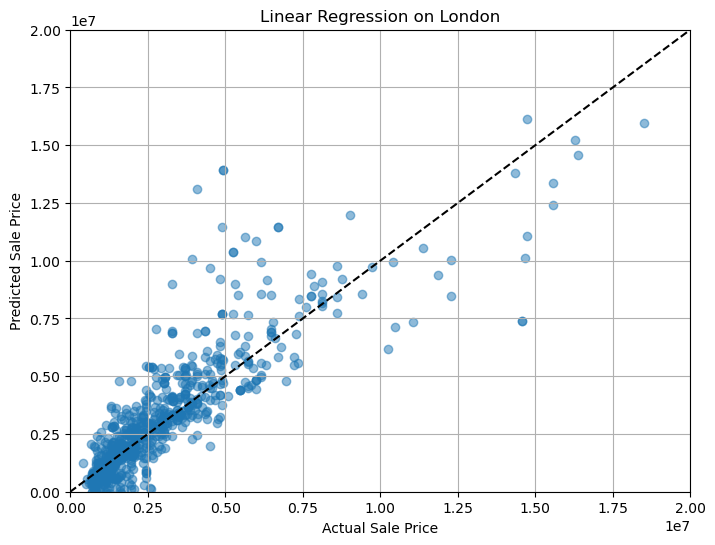

In [548]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions_test, alpha=0.5)
lims = [min(y_test.min(), predictions_test.min()), max(y_test.max(), predictions_test.max())]
plt.plot(lims, lims, color='black', linestyle='--')
plt.xlim(0, 2e7)
plt.ylim(0, 2e7)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Linear Regression on London")
plt.grid(True)
plt.show()

## Ridge Regression

### Tuning on Validation Set

In [549]:
alphas = [(0.01 * i) for i in range(100)]
best_alpha = None
best_rmse  = float("inf")

for alpha in alphas:
    model = Pipeline([
        ("prep", preprocess),
        ("reg",  Ridge(alpha=alpha))
    ])
    model.fit(X_train, y_train)
    preds_val = model.predict(X_val)
    rmse_val  = np.sqrt(mean_squared_error(y_val, preds_val))
    print(f"alpha={alpha:<5} → Val RMSE: {rmse_val:,.2f}")
    if rmse_val < best_rmse:
        best_rmse  = rmse_val
        best_alpha = alpha

print(f"\nBest alpha on validation: {best_alpha} (RMSE={best_rmse:,.2f})")

alpha=0.0   → Val RMSE: 1,821,466.32
alpha=0.01  → Val RMSE: 1,819,173.77
alpha=0.02  → Val RMSE: 1,817,961.86
alpha=0.03  → Val RMSE: 1,816,679.38
alpha=0.04  → Val RMSE: 1,815,818.38
alpha=0.05  → Val RMSE: 1,815,132.80
alpha=0.06  → Val RMSE: 1,814,930.09
alpha=0.07  → Val RMSE: 1,814,875.86
alpha=0.08  → Val RMSE: 1,814,963.53
alpha=0.09  → Val RMSE: 1,815,229.01
alpha=0.1   → Val RMSE: 1,815,194.54
alpha=0.11  → Val RMSE: 1,815,753.04
alpha=0.12  → Val RMSE: 1,816,438.57
alpha=0.13  → Val RMSE: 1,817,196.61
alpha=0.14  → Val RMSE: 1,818,036.26
alpha=0.15  → Val RMSE: 1,818,946.89
alpha=0.16  → Val RMSE: 1,819,946.89
alpha=0.17  → Val RMSE: 1,820,969.92
alpha=0.18  → Val RMSE: 1,822,058.29
alpha=0.19  → Val RMSE: 1,823,154.45
alpha=0.2   → Val RMSE: 1,824,358.72
alpha=0.21  → Val RMSE: 1,825,573.04
alpha=0.22  → Val RMSE: 1,826,344.42
alpha=0.23  → Val RMSE: 1,827,627.57
alpha=0.24  → Val RMSE: 1,829,400.80
alpha=0.25  → Val RMSE: 1,830,288.50
alpha=0.26  → Val RMSE: 1,831,675.07
a

In [550]:
model = Pipeline([
    ("prep", preprocess),
    ("reg",  Ridge(alpha=best_alpha))
])

# Combine train and val for training set
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

model.fit(X_trainval, y_trainval)

print('***** Results of ridge regression model on London dataset *****')

predictions_train = model.predict(X_trainval)
score_mse_train = mean_squared_error(y_trainval, predictions_train)
score_rmse_train = np.sqrt(score_mse_train)
print('Training set RMSE: {:.4f}'.format(score_rmse_train))

score_r2_train = r2_score(y_trainval, predictions_train)
print('Training set r-squared scores: {:.4f}'.format(score_r2_train))

predictions_test = model.predict(X_test)
score_mse_test = mean_squared_error(y_test, predictions_test)
score_rmse_test = np.sqrt(score_mse_test)
print('Testing set RMSE: {:.4f}'.format(score_rmse_test))

score_r2_test = r2_score(y_test, predictions_test)
print('Testing set r-squared scores: {:.4f}'.format(score_r2_test))

mean_price = predictions_test.mean()
print(f"Mean Price: {mean_price}")

***** Results of ridge regression model on London dataset *****
Training set RMSE: 1177988.6804
Training set r-squared scores: 0.9054
Testing set RMSE: 1865249.2933
Testing set r-squared scores: 0.6132
Mean Price: 3061653.530901004


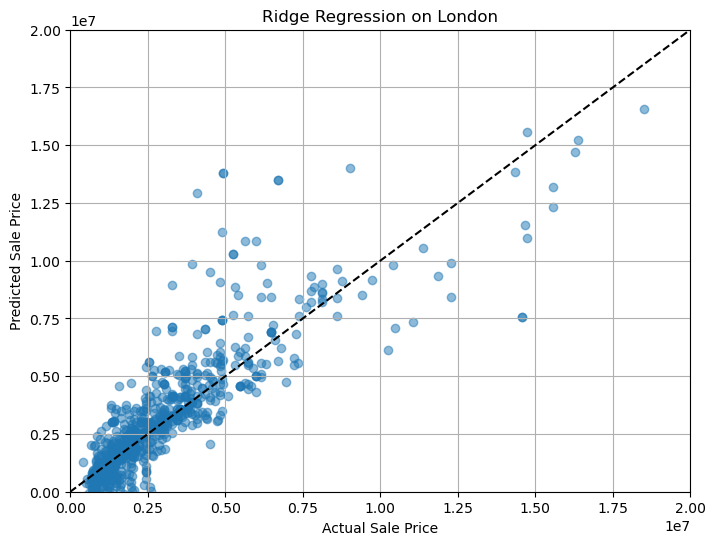

In [551]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions_test, alpha=0.5)
lims = [min(y_test.min(), predictions_test.min()), max(y_test.max(), predictions_test.max())]
plt.plot(lims, lims, color='black', linestyle='--')
plt.xlim(0, 2e7)
plt.ylim(0, 2e7)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Ridge Regression on London")
plt.grid(True)
plt.show()

# Teacher-student Model

## Preprocessing

In [552]:
parents = df[df["city"].isin(
    ["King County", "Melbourne", "New York", "Perth"]
)].copy()
london  = df[df["city"].str.lower() == "london"].copy()

X_par, y_par = parents.drop(columns=["sale_price", "sale_price_usd", "sale_price_usd_inflation_adjusted"]), parents["sale_price_usd_inflation_adjusted"]
X_lon, y_lon = london .drop(columns=["sale_price", "sale_price_usd", "sale_price_usd_inflation_adjusted"]), london["sale_price_usd_inflation_adjusted"]

cat_cols = X_par.select_dtypes(include=["object","category"]).columns
X_par[cat_cols] = X_par[cat_cols].astype(str)
X_lon[cat_cols] = X_lon[cat_cols].astype(str)

num_cols = X_par.select_dtypes(include=["int64","float64"]).columns

In [553]:
# Do parent split (80/20) for training/validation
X_P_train, X_P_val, y_P_train, y_P_val = train_test_split(
    X_par, y_par, test_size=0.20, random_state=42
)

# Do student split (70/15/15) for training/validation/test
X_L_temp, X_L_test, y_L_temp, y_L_test = train_test_split(
    X_lon, y_lon, test_size=0.15, random_state=42
)

X_L_train, X_L_val, y_L_train, y_L_val = train_test_split(
    X_L_temp, y_L_temp, test_size=0.17647, random_state=42
)

print(f"Parent Train/Val sizes: {len(X_P_train)}/{len(X_P_val)}")
print(f"London Train/Val/Test sizes: {len(X_L_train)}/{len(X_L_val)}/{len(X_L_test)}")

Parent Train/Val sizes: 59257/14815
London Train/Val/Test sizes: 4000/858/858


In [554]:
preprocess_parent = ColumnTransformer([
    ("num", Pipeline([
        ("imp",   SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp",   SimpleImputer(strategy="constant", fill_value="missing")),
        ("oh",    OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
], remainder="drop")

preprocess_london = ColumnTransformer([
    ("num", Pipeline([
        ("imp",   SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp",   SimpleImputer(strategy="constant", fill_value="missing")),
        ("oh",    OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
], remainder="drop")

### Tuning the Validation Set for Parent

In [555]:
alphas = [(20 * i) for i in range(50)]
best_alpha = None
best_rmse  = float("inf")

for alpha in alphas:
    teacher = Pipeline([
        ("prep", preprocess_parent),
        ("reg",  Ridge(alpha=alpha))
    ])
    teacher.fit(X_P_train, y_P_train)
    preds_val = teacher.predict(X_P_val)
    rmse_val  = np.sqrt(mean_squared_error(y_P_val, preds_val))
    print(f"alpha={alpha:<5} → Val RMSE: {rmse_val:,.2f}")
    if rmse_val < best_rmse:
        best_rmse  = rmse_val
        best_alpha = alpha

print(f"\nBest alpha on validation: {best_alpha} (RMSE={best_rmse:,.2f})")

teacher = Pipeline([
    ("prep", preprocess_parent),
    ("reg",  Ridge(alpha=best_alpha))
])
teacher.fit(X_par, y_par)

alpha=0     → Val RMSE: 2,201,759.30
alpha=20    → Val RMSE: 1,535,693.10
alpha=40    → Val RMSE: 1,298,948.31
alpha=60    → Val RMSE: 1,189,419.55
alpha=80    → Val RMSE: 1,130,975.27
alpha=100   → Val RMSE: 1,096,662.77
alpha=120   → Val RMSE: 1,075,114.08
alpha=140   → Val RMSE: 1,060,891.68
alpha=160   → Val RMSE: 1,051,104.45
alpha=180   → Val RMSE: 1,044,162.87
alpha=200   → Val RMSE: 1,039,089.90
alpha=220   → Val RMSE: 1,035,348.52
alpha=240   → Val RMSE: 1,032,517.70
alpha=260   → Val RMSE: 1,030,350.64
alpha=280   → Val RMSE: 1,028,635.54
alpha=300   → Val RMSE: 1,027,327.31
alpha=320   → Val RMSE: 1,026,294.43
alpha=340   → Val RMSE: 1,025,473.96
alpha=360   → Val RMSE: 1,024,818.66
alpha=380   → Val RMSE: 1,024,291.82
alpha=400   → Val RMSE: 1,023,870.86
alpha=420   → Val RMSE: 1,023,530.43
alpha=440   → Val RMSE: 1,023,256.12
alpha=460   → Val RMSE: 1,023,035.14
alpha=480   → Val RMSE: 1,022,857.31
alpha=500   → Val RMSE: 1,022,700.58
alpha=520   → Val RMSE: 1,022,590.39
a

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['bedrooms', 'bathrooms', 'living_area', 'latitude', 'longitude',
       'total_venues', 'avg_venue_rating', 'avg_venue_popularity',
       'num_dining_drinking', 'num_retail_shopping', 'num_education',
       'num_recreation',...sportation',
       'num_healthcare', 'num_professional', 'num_high_rating_venues',
       'median_income'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('oh',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['postcode', 'city', 'country', 'dataset_date', 'currency'], dtype='object'))])),
                ('reg', Ridge(alpha=720))])

### Tuning the Validation Set for Student

In [556]:
# Define grids
ridge_alphas  = [0.01 * i for i in range(1, 101)]   # 0.01, 0.02, …, 1.0
distill_thetas = [0.05 * i for i in range(6, 15)]    # 0.3, …, 0.7

best_rmse     = float("inf")
best_ridge    = None
best_theta    = None

# Grid search over
for ridge_alpha in ridge_alphas:
    for theta in distill_thetas:
        # Generate pseudo‐labels with current theta
        z_T        = teacher.predict(X_L_train)
        y_pseudo   = theta * y_L_train.values + (1 - theta) * z_T

        # Train student with current ridge_alpha
        student = Pipeline([
            ("prep", preprocess_london),
            ("reg",  Ridge(alpha=ridge_alpha))
        ])
        student.fit(X_L_train, y_pseudo)

        # Evaluate on validation set
        preds_val = student.predict(X_L_val)
        rmse_val  = np.sqrt(mean_squared_error(y_L_val, preds_val))
        print(f"ridge_alpha={ridge_alpha:<5}, theta={theta:<5} → Val RMSE: {rmse_val:,.2f}")

        # Track best
        if rmse_val < best_rmse:
            best_rmse  = rmse_val
            best_ridge = ridge_alpha
            best_theta = theta

print(f"\nBest configuration → Ridge α = {best_ridge}, θ = {best_theta}  (Val RMSE = {best_rmse:,.2f})")

ridge_alpha=0.01 , theta=0.30000000000000004 → Val RMSE: 3,105,105.91
ridge_alpha=0.01 , theta=0.35000000000000003 → Val RMSE: 2,969,409.20
ridge_alpha=0.01 , theta=0.4   → Val RMSE: 2,836,837.95
ridge_alpha=0.01 , theta=0.45  → Val RMSE: 2,708,947.15
ridge_alpha=0.01 , theta=0.5   → Val RMSE: 2,585,564.47
ridge_alpha=0.01 , theta=0.55  → Val RMSE: 2,467,655.25
ridge_alpha=0.01 , theta=0.6000000000000001 → Val RMSE: 2,356,009.91
ridge_alpha=0.01 , theta=0.65  → Val RMSE: 2,251,624.37
ridge_alpha=0.01 , theta=0.7000000000000001 → Val RMSE: 2,155,492.25
ridge_alpha=0.02 , theta=0.30000000000000004 → Val RMSE: 3,108,770.37
ridge_alpha=0.02 , theta=0.35000000000000003 → Val RMSE: 2,973,328.73
ridge_alpha=0.02 , theta=0.4   → Val RMSE: 2,841,412.56
ridge_alpha=0.02 , theta=0.45  → Val RMSE: 2,713,548.24
ridge_alpha=0.02 , theta=0.5   → Val RMSE: 2,590,678.39
ridge_alpha=0.02 , theta=0.55  → Val RMSE: 2,472,843.24
ridge_alpha=0.02 , theta=0.6000000000000001 → Val RMSE: 2,361,275.06
ridge_alp

### Training Student with Best Hyperparameters

In [557]:
# Concat train and val
X_L_trainval = pd.concat([X_L_train, X_L_val], axis=0)
y_L_trainval = pd.concat([y_L_train, y_L_val], axis=0)

# teacher predictions on London train
z_T = teacher.predict(X_L_trainval)

# Joint loss pseudo labels
y_pseudo = best_theta * y_L_trainval.values + (1 - best_theta) * z_T

# Ridge on London with pseudo labels
student = Pipeline([
    ("prep", preprocess_london),
    ("reg",  Ridge(alpha=best_ridge))
])
student.fit(X_L_trainval, y_pseudo)

# Final evaluation
print('***** Results of teacher-student on London dataset *****')

predictions_train = student.predict(X_L_trainval)
score_mse_train = mean_squared_error(y_L_trainval, predictions_train)
score_rmse_train = np.sqrt(score_mse_train)
print('Training set RMSE: {:.4f}'.format(score_rmse_train))

score_r2_train = r2_score(y_L_trainval, predictions_train)
print('Training set r-squared scores: {:.4f}'.format(score_r2_train))

predictions_test = student.predict(X_L_test)
score_mse_test = mean_squared_error(y_L_test, predictions_test)
score_rmse_test = np.sqrt(score_mse_test)
print('Testing set RMSE: {:.4f}'.format(score_rmse_test))

score_r2_test = r2_score(y_L_test, predictions_test)
print('Testing set r-squared scores: {:.4f}'.format(score_r2_test))

mean_price = predictions_test.mean()
print(f"Mean Price: {mean_price}")

***** Results of teacher-student on London dataset *****
Training set RMSE: 1519867.4023
Training set r-squared scores: 0.8425
Testing set RMSE: 1531370.8834
Testing set r-squared scores: 0.7393
Mean Price: 2814875.6286545


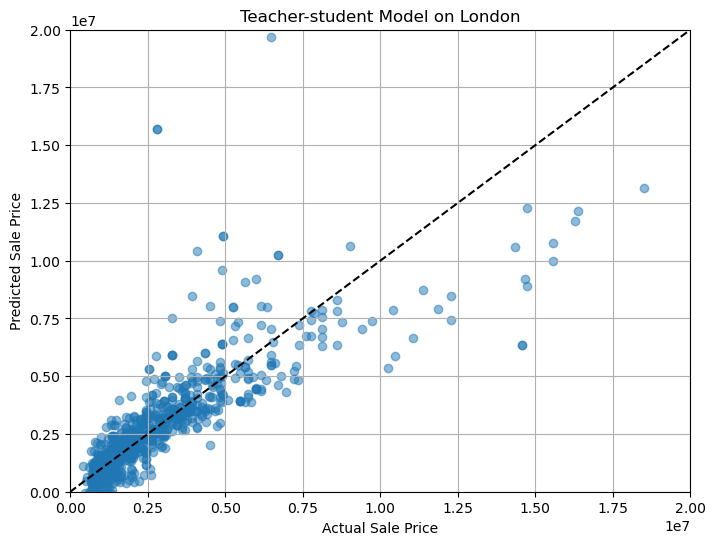

In [558]:
plt.figure(figsize=(8, 6))
plt.scatter(y_L_test, predictions_test, alpha=0.5)
lims = [min(y_L_test.min(), predictions_test.min()), max(y_L_test.max(), predictions_test.max())]
plt.plot(lims, lims, color='black', linestyle='--')
plt.xlim(0, 2e7)
plt.ylim(0, 2e7)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Teacher-student Model on London")
plt.grid(True)
plt.show()